## Notes sur le laboratoire

### Utilisation de commandes

Dans ce laboratoire, il est parfois intéressant (mais pas nécessaire à strictement parler) d'entrer certaines commandes dans le terminal (ou ligne de commande). Dans l'explorateur de fichiers de Jupyter Notebook, il est très simple d'ouvrir un terminal via le menu New (ou Nouveau):

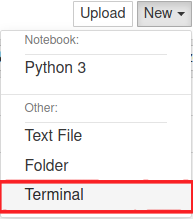

Par contre, il n'est malheureusement pas possible d'obtenir un terminal si Google Colab est utilisé.

### Utilisation de Google Colab

Si vous utilisez Google Colab, suivez les instructions ci-dessous.

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 1: Introduction à PyTorch

Le but de ce laboratoire est de se familiariser avec PyTorch en l'utilisant pour faire de la classification sur deux jeux de données connus: MNIST et CIFAR-10. On aura donc une vue d'ensemble de l'utilisation de PyTorch. Prenez donc le temps de lire le code et d'essayer de comprendre en haut niveau ce qui se passe.

La cellule ci-dessous importe les différents modules qui sont utilisés dans ce notebook. Notamment, en plus de différents modules de PyTorch (torch.\*), on importe deeplib qui est une libraire écrite spécialement pour les notebook de ce cours.

In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 150

from deeplib.datasets import load_mnist, load_cifar10, train_valid_loaders
from sklearn.metrics import accuracy_score
from deeplib.net import MnistNet, CifarNet
from deeplib.history import History
from deeplib.visualization import plot_images

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

## MNIST

MNIST est un jeu de données contenant des images de chiffres manuscrits.

Le jeu de données est séparé comme suit: 50 000 images sont utilisées en entraînement et 10 000 en test.

Pour obtenir les objets [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) de PyTorch pour les exemples d'entraînement et de test, on utilise la fonction `load_mnist` dans deeplib qui utilise la librairie [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) sous le capot.

In [3]:
mnist, mnist_test = load_mnist()

### Visualisation du jeu de données

Exécuter cette cellule plusieurs fois pour visualiser différents exemples du jeu de données.

La fonction `plot_images` est une fonction venant de deeplib.

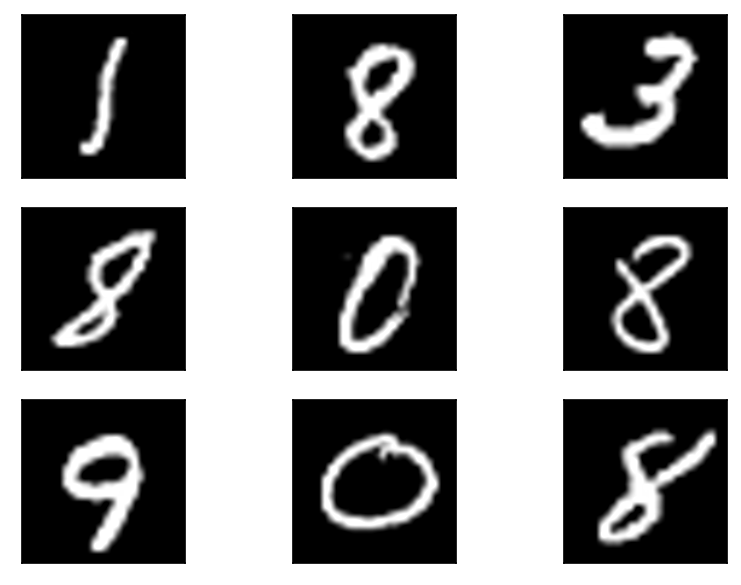

In [4]:
idx = random.sample([x for x in range(len(mnist))], 9)
images = [np.array(mnist[i][0]) for i in idx]
targets = [mnist[i][1] for i in idx]

plot_images(images, targets, gray=True)

On peut indexer les datasets de PyTorch comme une liste. Généralement, chaque élément d'un dataset va être un tuple `(x, y)`. Le terme `x` va correspondre à notre exemple. Le terme `y` va correspondre à notre étiquette (ou label, target) sous forme d'index (par exemple, on pourrait avoir 0 pour chien et 1 pour chat si on cherchait à différencier des images de chats et de chien). Avec MNIST, `x` sera les pixels de l'image et `y` sera le chiffre à classifier.

Les cellules ci-dessous affichent le premier élément `(x, y)` du jeu de données.

In [5]:
x, y = mnist[0]
x, y

(<PIL.Image.Image image mode=L size=28x28 at 0x7F8A19514790>, 5)

On affiche l'image `x`.

In [6]:
x

On affiche l'étiquette `y`.

In [7]:
y

5

Les datasets de torchvision ont un attribut permettant d'effectuer une transformation sur nos images. Dans notre cas, on veut simplement obtenir un tenseur pour PyTorch.

In [8]:
mnist.transform = ToTensor()
mnist_test.transform = ToTensor()

## Entraînement

Pour l'entraînement, on a besoin d'une fonction ``train`` pour entraîner le réseau, d'une fonction ``validate`` pour estimer la performance de notre modèle au fur et à mesure de l'optimisation et d'une fonction ``test`` pour estimer la performance de notre modèle sur des données jamais observées.

Pour chaque epoch, la fonction ``train`` passe au travers de toutes les images du jeu de données dans un ordre aléatoire et met à jour les poids du réseau selon la perte calculée.<br>
Pour entraîner le réseau, la fonction doit recevoir 3 hyperparamètres: 
1. le nombre d'epochs qui indique combien de fois toutes les images du jeu de données seront observées; 
2. la taille de la batch qui indique combien d'images seront traitées à la fois;
3. le taux d'apprentissage qui détermine la vitesse à laquelle chaque poids du réseau sera modifié.

Pendant l'entraînement, une partie des données est utilisée pour créer un ensemble de validation qui permet d'estimer les performances de généralisation du modèle.

Finalement, on sauvegarde aussi quelques informations importantes afin de visualiser ce qui se passe pendant l'entraînement.

Le code est commenté pour donner plus de détails du déroulement de l'entraînement et des subtilités de PyTorch. Vous aurez l'occasion dans les prochains laboratoires de mieux comprendre tous ces détails.

In [9]:
def train(model, dataset, n_epoch, batch_size, learning_rate, use_gpu=False):
    """
    Entraîne un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        dataset (Dataset): Un jeu de données PyTorch.
        n_epoch (int): Le nombre d'epochs.
        batch_size (int): La taille des batchs.
        learning_rate (float): Le taux d'apprentissage pour SGD.
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
    
    Returns:
        Retourne un objet History permettant de faire des graphiques
        de l'évolution de l'entraînement.
    """
    # La classe History vient de deeplib. Elle va nous permettre de faire les graphiques
    # donnant l'évolution de la perte et de l'exactitude (accuracy).
    history = History()
    
    # La fonction de perte que nous utilisons ici est l'entropy croisée
    # L'optimiseur que nous utilisons ici est le classique SGD.
    # Des liens vers la documentation de PyTorch sont en commentaires.
    criterion = nn.CrossEntropyLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # https://pytorch.org/docs/stable/optim.html#torch.optim.SGD
    
    # La fonction train_valid_loaders vient de deeplib. Elle nous retourne deux DataLoaders:
    # un pour l'ensemble d'entraînement et un pour l'ensemble de test. Essentiellement,
    # DataLoader est une classe de PyTorch nous permettant de faire des batchs avec la taille
    # désirée. La fonction train_valid_loaders effectue la répartition aléatoire des exemples
    # en entraînement et en validation.
    train_loader, valid_loader = train_valid_loaders(dataset, batch_size=batch_size)

    # C'est ici que la boucle d'entraînement commence. On va donc faire n_epochs epochs.
    for i in range(n_epoch):
        # Les réseaux de neurones avec PyTorch ont un méthode train() en plus d'une méthode 
        # eval(). Ces deux méthodes indiquent au réseau s'il est en entraînement ou bien en test.
        # Ceci permet au réseau de modifier son comportement en fonction. On va le voir plus tard
        # certaines couches agissent différemment selon le mode, nommément le dropout et la 
        # batch normalization.
        model.train()
        
        # La prochaine ligne active simplement le calcul du gradient. Le gradient est ce qui va
        # nous permettre de mettre à jour les poids du réseau de neurones. En test, le calcul du
        # gradient sera désactivé étant qu'il n'est pas nécessaire et qu'il peut engendrer des 
        # fuites de mémoire si la rétro-propagation n'est pas effectuée.
        with torch.enable_grad():
            # À chaque epoch, on parcourt l'ensemble d'entraînement au complet via le DataLoader
            # qui nous le retourne en batch (x, y) comme mentionné plus haut. La variable inputs 
            # correspond donc à une batch d'exemples (x) et targets correspond à une batch 
            # d'étiquettes (y).
            for inputs, targets in train_loader:
                # On envoie les exemples et leurs étiquettes sur GPU via la méthode cuda() si 
                # demandé.
                if use_gpu:
                    inputs = inputs.cuda()
                    targets = targets.cuda()

                # La méthode zero_grad() de l'optimiseur permet de mettre la valeur du gradient
                # à zéro de façon à effacer le gradient calculé auparavant. Si ceci n'était pas 
                # fait, le nouveau gradient serait additionné à l'ancien gradient ce qui poserait
                # problème.
                optimizer.zero_grad()
                
                # C'est ici que finalement le réseau de neurones est appelé. On lui donne en entrée
                # un exemple et en sortie il nous donne ses prédictions (ici, des scores de 
                # classification).
                output = model(inputs)

                # Une fois nos prédictions obtenues, on calcule la perte avec la fonction de perte 
                # qui nous retourne un tenseur scalaire. 
                loss = criterion(output, targets)
                # Ce tenseur scalaire nous permet de calculer le gradient. C'est ce que la méthode
                # backward() vient faire pour nous via la rétropropagation.
                loss.backward()
                # Une fois que le gradient est calculé, il ne reste que mettre à jour les poids du
                # réseau de neurones. C'est ce que la méthode step() de l'optimiseur vient faire
                # pour nous.
                optimizer.step()

        # Après chaque epoch d'entraînement, on va venir calculer la perte et l'exactitude 
        # (accuracy) sur l'ensemble d'entraînement et de validation.
        train_acc, train_loss = validate(model, train_loader, use_gpu)
        val_acc, val_loss = validate(model, valid_loader, use_gpu)
        history.save(dict(acc=train_acc, val_acc=val_acc, loss=train_loss, val_loss=val_loss, lr=learning_rate))
        print(f'Epoch {i} - Train acc: {train_acc:.2f} - Val acc: {val_acc:.2f} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f}')

    return history

Pour chaque image du jeu de donnée, la fonction ``validate`` fait prédire une classe au réseau entraîné et compare le résultat avec la vraie réponse. Elle retourne le pourcentage de réponse correcte (c'est-à-dire l'exactitude, ou *accuracy* en anglais) ainsi que la perte moyenne.

In [10]:
def validate(model, valid_loader, use_gpu=False):
    """
    Test un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        valid_loader (DataLoader): Un DataLoader PyTorch tel qu'instancié dans train() 
            et test().
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
            
    Returns:
        Retourne un tuple (exactitude, perte) pour les données du DataLoader en argument.
    """
    
    # Les étapes de la fonction validate est très similaire à celle de la fonction train.
    # Essentiellement, le réseau est mis en mode évaluation au lieu d'entraînement et le 
    # calcul du gradient est désactivé. Il n'y a bien sûr pas d'utilisation d'un optimiseur.
    true = []
    pred = []
    val_loss = []
    
    criterion = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            if use_gpu:
                inputs = inputs.cuda()
                targets = targets.cuda()

            output = model(inputs)

            predictions = output.max(dim=1)[1]

            val_loss.append(criterion(output, targets).item())
            true += targets.cpu().numpy().tolist()
            pred += predictions.cpu().numpy().tolist()

    return accuracy_score(true, pred) * 100, sum(val_loss) / len(val_loss)

La fonction `test` est utilisée à la fin de l'entraînement sur l'ensemble de test et affiche le pourcentage de réponse correcte ainsi que la perte moyenne sur cet ensemble.

In [11]:
def test(model, dataset, batch_size, use_gpu=False):
    """
    Test un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch. La fonction affiche l'exactitude et la perte moyenne.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        dataset (Dataset): Un jeu de données PyTorch.
        batch_size (int): La taille des batchs.
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
    """
    test_loader = DataLoader(dataset, batch_size=batch_size)
    test_acc, test_loss = validate(model, test_loader, use_gpu=use_gpu)
    print('Test acc: {:.2f} - Test loss: {:.4f}'.format(test_acc, test_loss))

Entraînons un modèle.

In [12]:
model = MnistNet()
model.cuda()

n_epoch = 10
batch_size = 64
learning_rate = 0.1

history = train(model, mnist, n_epoch, batch_size, learning_rate, use_gpu=True)

Epoch 0 - Train acc: 96.53 - Val acc: 96.43 - Train loss: 0.1113 - Val loss: 0.1164
Epoch 1 - Train acc: 97.88 - Val acc: 97.70 - Train loss: 0.0674 - Val loss: 0.0730
Epoch 2 - Train acc: 98.25 - Val acc: 97.51 - Train loss: 0.0578 - Val loss: 0.0751
Epoch 3 - Train acc: 99.20 - Val acc: 98.70 - Train loss: 0.0272 - Val loss: 0.0428
Epoch 4 - Train acc: 99.22 - Val acc: 98.65 - Train loss: 0.0261 - Val loss: 0.0444
Epoch 5 - Train acc: 99.47 - Val acc: 98.84 - Train loss: 0.0175 - Val loss: 0.0373
Epoch 6 - Train acc: 99.62 - Val acc: 99.08 - Train loss: 0.0136 - Val loss: 0.0321
Epoch 7 - Train acc: 99.46 - Val acc: 98.85 - Train loss: 0.0158 - Val loss: 0.0428
Epoch 8 - Train acc: 99.70 - Val acc: 98.84 - Train loss: 0.0102 - Val loss: 0.0385
Epoch 9 - Train acc: 99.86 - Val acc: 99.07 - Train loss: 0.0064 - Val loss: 0.0324


En utilisant la méthode `display` de la classe `History`, on peut visualiser l'entraînement précédent.

Le premier graphique montre l'évolution de l'exactitude (accuracy) du modèle sur le jeu de données d'entraînement et sur celui de validation. Le deuxième montre la perte sur les deux jeux de données.

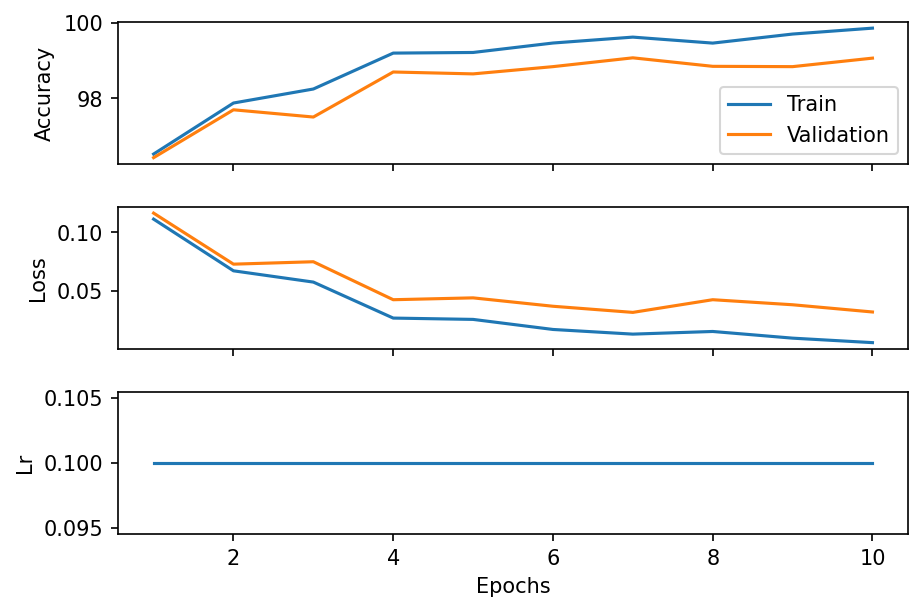

In [13]:
history.display()

Finalement, évaluons les performances du modèle sur le jeu de données de test.

In [14]:
test(model, mnist_test, batch_size, use_gpu=True)

Test acc: 99.11 - Test loss: 0.0310


## Différences CPU - GPU

Pour faire exécuter le code sur GPU, il faut déplacer le model, les inputs et les targets sur le GPU. 

Le réseau contient deux couches de convolutions qui servent à extraire des caractéristiques des images tandis que les couches linéaires servent de classifieur. Il s'agit d'un pipeline commun pour toutes les classes.

In [15]:
model_gpu = MnistNet()
model_gpu.cuda()

MnistNet(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2450, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Comparons le temps d'exécution sur CPU et sur GPU. Pour ce faire, entraînons le réseau pour 5 epochs sur CPU et 5 epochs sur GPU et comparons les temps de traitement.

In [16]:
epoch = 5
batch_size = 256
lr = 0.1

Pendant l'entraînement, vérifier l'utilisation du CPU avec la commande ``top`` (ou ``htop``). Voir la section "Utilisation de commandes" tout en haut du notebook pour l'utilisation de commande.

In [17]:
print('Training on CPU')
model = MnistNet()

start_cpu = time.time()
history = train(model, mnist, epoch, batch_size, lr)
end_cpu = time.time()

cpu_time = end_cpu - start_cpu

Training on CPU
Epoch 0 - Train acc: 77.81 - Val acc: 77.31 - Train loss: 0.6542 - Val loss: 0.6598
Epoch 1 - Train acc: 92.74 - Val acc: 92.58 - Train loss: 0.2253 - Val loss: 0.2241
Epoch 2 - Train acc: 96.48 - Val acc: 96.12 - Train loss: 0.1175 - Val loss: 0.1252
Epoch 3 - Train acc: 97.38 - Val acc: 97.08 - Train loss: 0.0850 - Val loss: 0.0909
Epoch 4 - Train acc: 97.84 - Val acc: 97.48 - Train loss: 0.0697 - Val loss: 0.0789


Pour vous assurer que le réseau entraîne bien sur GPU, utiliser la commande 

``watch -n 1 nvidia-smi`` 

Observer l'utilisation de la carte et la quantité de mémoire utilisée pendant l'entraînement.

In [18]:
print('Training on GPU')
model_gpu = MnistNet()
model_gpu.cuda()

start_gpu = time.time()
history_gpu = train(model_gpu, mnist, epoch, batch_size, lr, use_gpu=True)
end_gpu = time.time()

gpu_time = end_gpu - start_gpu

Training on GPU
Epoch 0 - Train acc: 87.22 - Val acc: 87.20 - Train loss: 0.4098 - Val loss: 0.4102
Epoch 1 - Train acc: 94.42 - Val acc: 94.30 - Train loss: 0.1740 - Val loss: 0.1795
Epoch 2 - Train acc: 96.31 - Val acc: 96.11 - Train loss: 0.1192 - Val loss: 0.1217
Epoch 3 - Train acc: 96.75 - Val acc: 96.42 - Train loss: 0.1035 - Val loss: 0.1077
Epoch 4 - Train acc: 97.95 - Val acc: 97.47 - Train loss: 0.0679 - Val loss: 0.0749


In [19]:
print('CPU - Training time: {:.2f}s'.format(cpu_time))
print('GPU - Training time: {:.2f}s'.format(gpu_time))
print('Ratio: {:.2f}x'.format((cpu_time) / (gpu_time)))

CPU - Training time: 80.32s
GPU - Training time: 38.64s
Ratio: 2.08x


## CIFAR 10

CIFAR-10 est un jeu de données comportant des images séparés en 10 classes:<br>
0 - Avion<br>
1 - Voiture<br>
2 - Oiseau<br>
3 - Chat<br>
4 - Chevreuil<br>
5 - Chien<br>
6 - Grenouille<br>
7 - Cheval<br>
8 - Bateau<br>
9 - Camion<br>

Le jeu de données contient 50000 images d'entraînement. On en utilisera 40000 pour l'entraînement et 10000 pour la validation.

### Visualisation du jeu de données

In [20]:
cifar, cifar_test = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


Encore une fois, vous pouvez exécuter cette cellule plusieurs fois pour bien visualiser le jeu de données.

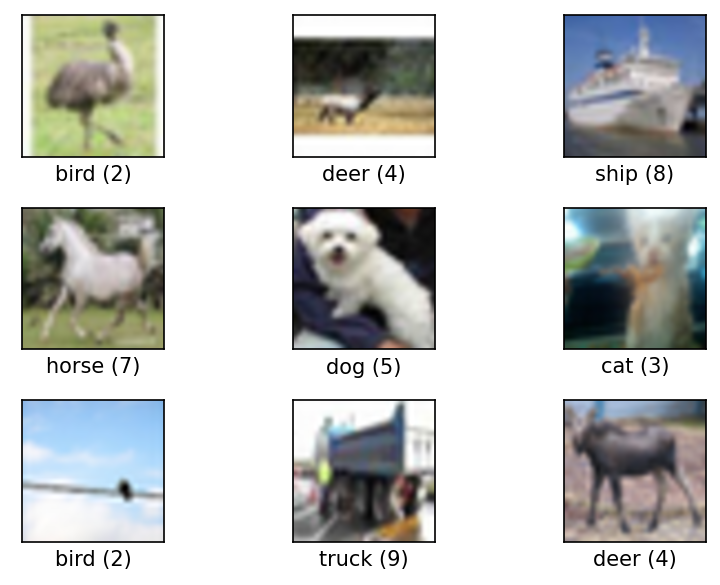

In [21]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

idx = random.sample([x for x in range(len(cifar))], 9)
images = [np.array(cifar[i][0]) for i in idx]
images = np.asarray(images)
targets = [cifar[i][1] for i in idx]

plot_images(images, targets, label_names=label_names)

Encore une fois, on désire obtenir des tensors de notre dataset.

In [22]:
cifar.transform = ToTensor()
cifar_test.transform = ToTensor()

#### Exercices

- Utilisez les 3 cellules suivantes pour répondre aux questions.

In [23]:
epoch = 5
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)

Epoch 0 - Train acc: 46.91 - Val acc: 44.97 - Train loss: 1.4595 - Val loss: 1.5023
Epoch 1 - Train acc: 58.20 - Val acc: 55.08 - Train loss: 1.1901 - Val loss: 1.2632
Epoch 2 - Train acc: 61.60 - Val acc: 56.83 - Train loss: 1.0941 - Val loss: 1.2228
Epoch 3 - Train acc: 70.25 - Val acc: 64.06 - Train loss: 0.8787 - Val loss: 1.0245
Epoch 4 - Train acc: 75.89 - Val acc: 67.13 - Train loss: 0.7270 - Val loss: 0.9494


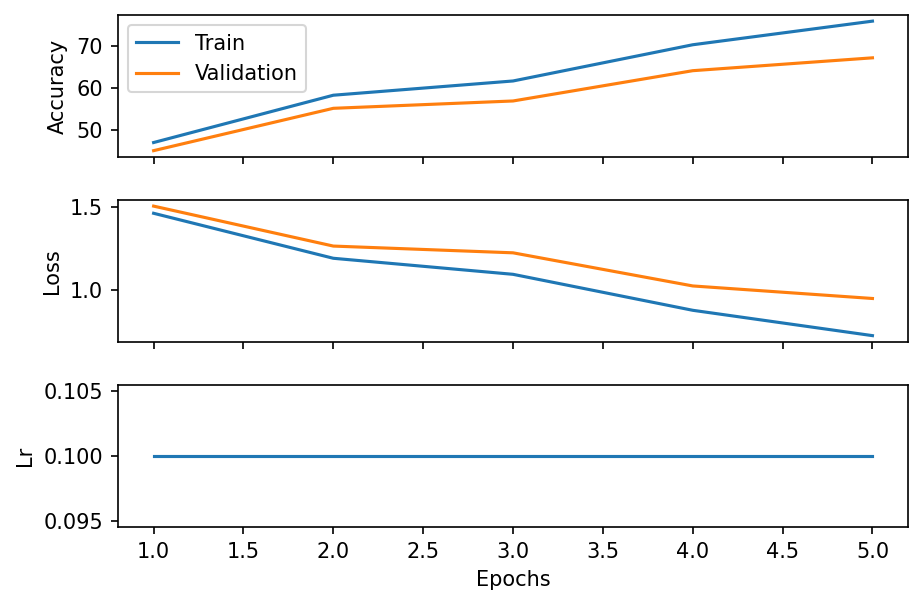

In [24]:
history.display()

In [25]:
test(model, cifar_test, batch_size, use_gpu=True)

Test acc: 67.25 - Test loss: 0.9567


### Effet du nombre d'epochs

#### Exercice

- Modifiez le nombre d'epochs et observez les performances du réseau.

#### Questions

- Que se passe-t-il s'il est trop petit?

    **Ceci est équivalent à arrêter l'entraînement de manière prématuré. Donc, si on arrête l'entraînement après seulement 2 epochs par exemple, on voit clairement que notre modèle n'a pas été entraîné à son plein potentiel. On parle ici de sous-apprentissage.**

- Que se passe-t-il s'il est trop grand?

    **Ceci un exemple de surapprentissage. En surapprentissage, le réseau de neurones est capable de mémoriser les exemples d'entraînement. On peut le voir dans les courbes d'apprentissage ci-dessous. Dans la courbe de la fonction de perte, on peut voir que la perte en entraînement est très basse alors qu'en validation, elle descend au début de l'entraînement et monte sans cesse par la suite. Similairement, de manière plus subtile, l'exactitude en validation monte en premier et décroit par tranquillement par la suite.**

Epoch 0 - Train acc: 36.67 - Val acc: 35.50 - Train loss: 1.7350 - Val loss: 1.7631
Epoch 1 - Train acc: 53.88 - Val acc: 51.13 - Train loss: 1.3000 - Val loss: 1.3659
Epoch 2 - Train acc: 62.21 - Val acc: 58.64 - Train loss: 1.0748 - Val loss: 1.1660
Epoch 3 - Train acc: 64.78 - Val acc: 59.20 - Train loss: 1.0039 - Val loss: 1.1687
Epoch 4 - Train acc: 71.73 - Val acc: 64.39 - Train loss: 0.8117 - Val loss: 1.0187
Epoch 5 - Train acc: 74.57 - Val acc: 65.10 - Train loss: 0.7364 - Val loss: 1.0005
Epoch 6 - Train acc: 78.95 - Val acc: 67.35 - Train loss: 0.6245 - Val loss: 0.9533
Epoch 7 - Train acc: 81.48 - Val acc: 67.53 - Train loss: 0.5539 - Val loss: 0.9806
Epoch 8 - Train acc: 84.21 - Val acc: 67.50 - Train loss: 0.4780 - Val loss: 0.9964
Epoch 9 - Train acc: 87.47 - Val acc: 67.24 - Train loss: 0.3919 - Val loss: 1.0201
Epoch 10 - Train acc: 88.49 - Val acc: 67.18 - Train loss: 0.3522 - Val loss: 1.0676
Epoch 11 - Train acc: 88.59 - Val acc: 65.92 - Train loss: 0.3362 - Val los

Epoch 97 - Train acc: 92.62 - Val acc: 60.56 - Train loss: 0.4731 - Val loss: 7.2846
Epoch 98 - Train acc: 94.73 - Val acc: 60.97 - Train loss: 0.2750 - Val loss: 6.2083
Epoch 99 - Train acc: 93.32 - Val acc: 60.28 - Train loss: 0.3966 - Val loss: 7.0695


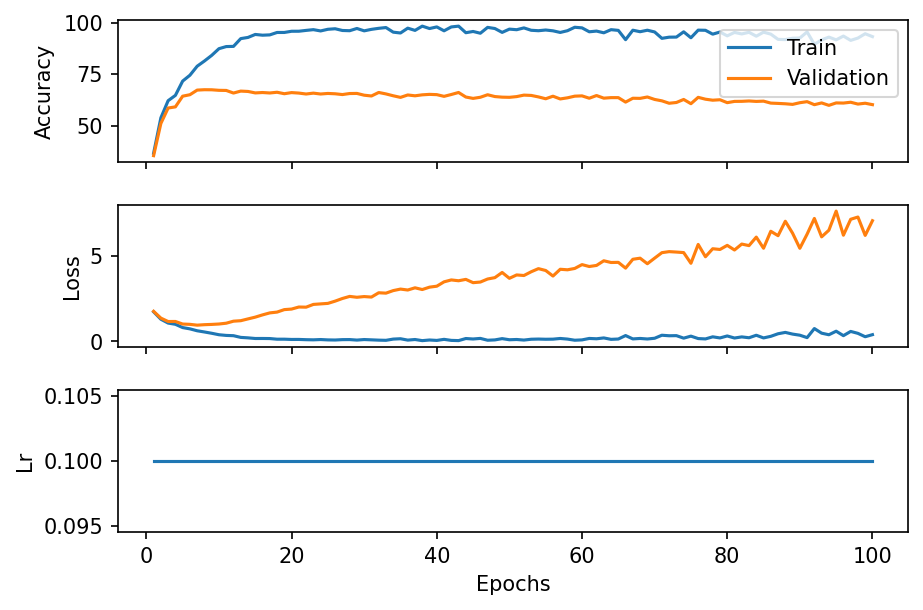

Test acc: 59.96 - Test loss: 7.2768


In [26]:
epoch = 100
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Effet de la taille de la batch

#### Exercice

- Modifiez la taille de la batch et observez l'utilisation de la carte graphique. 

#### Questions

- Sur quoi est-ce que la taille de la batch semble avoir le plus d'impact? 

    **Note**: Pour pouvoir observer les changements au niveau de l'utilisation de la mémoire du GPU, il est préférable de redémarrer le kernel du notebook entre chaque tentative (dans le menu Kernel). Si vous prenez ce chemin, n'oubliez pas d'exécuter les cellules nécessaires plus haut dans le notebook (les imports, les fonctions train, validate, etc.).

    **Évidemment, niveau mémoire GPU, la taille de la batch a une grande importance. Pour une batch très petite, peu de mémoire sera utilisé et pour une batch très grande, une grande quantité sera nécessaire. Au niveau de l'utilisation des coeurs du GPUs, plus la taille de la batch est grand, plus grande l'utilisation des coeurs sera. Une plus grande batch peut donc mener à une utilisation plus efficace des ressources de calcul qui sont limités. Par contre, il faut aussi prendre en compte que la taille de la batch a un impact sur les performances.**

- Est-ce qu'elle impacte les performances?

    **En effet, on note que si l'on va dans les extrêmes, les performances sont dégradées d'une manière ou d'une autre. Dépendamment du réseau et de son initialisation, ceci peut prendre la forme d'un apprentissage qui ne s'effectue simplement pas, un apprentissage plus lent ou bien à un grand surapprentissage. Ceci est du au fait que les réseaux de neurones ne sont pas des modèles dits convexes et donc ont besoin d'un certain niveau de stochaïsticité (c'est-à-dire de l'aléatoire) pour être capable de les entraîner. La taille de la batch est donc un hyperparamètre important pour avoir un apprentissage effectif.**

- Que peut-on conclure sur la taille de batch optimale?

     **Note**: on ne demande pas de trouver cette taille optimale mais de commenter sur la manière dont on la trouverait.

    **La taille de batch optimale sera donc un compromis entre l'utilisation optimale des ressources du GPUs et sur les performances obtenues. On peut donc tenter d'augmenter la taille de la batch tout en obtenant des performances optimales.**

Epoch 0 - Train acc: 9.99 - Val acc: 10.04 - Train loss: 2.3319 - Val loss: 2.3363
Epoch 1 - Train acc: 10.02 - Val acc: 9.93 - Train loss: 2.3535 - Val loss: 2.3528
Epoch 2 - Train acc: 9.98 - Val acc: 10.10 - Train loss: 2.3158 - Val loss: 2.3141
Epoch 3 - Train acc: 9.99 - Val acc: 10.04 - Train loss: 2.3164 - Val loss: 2.3184
Epoch 4 - Train acc: 9.99 - Val acc: 10.04 - Train loss: 2.3165 - Val loss: 2.3175


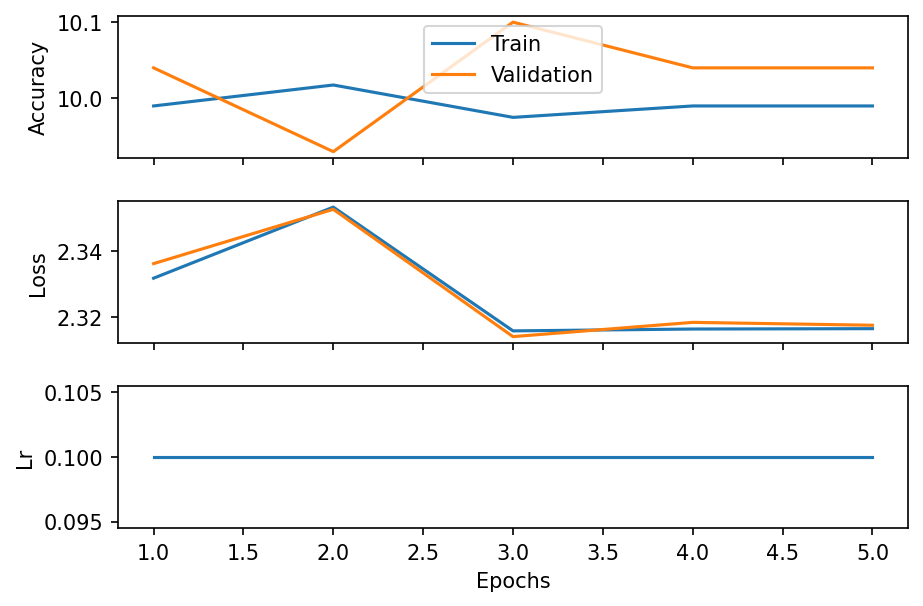

Test acc: 10.00 - Test loss: 2.3167


In [27]:
epoch = 5
batch_size = 1
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

Epoch 0 - Train acc: 26.41 - Val acc: 26.46 - Train loss: 2.1503 - Val loss: 2.1518
Epoch 1 - Train acc: 20.88 - Val acc: 21.04 - Train loss: 2.2311 - Val loss: 2.2308
Epoch 2 - Train acc: 18.07 - Val acc: 19.11 - Train loss: 2.2908 - Val loss: 2.2812
Epoch 3 - Train acc: 20.47 - Val acc: 20.65 - Train loss: 2.2024 - Val loss: 2.2076
Epoch 4 - Train acc: 25.16 - Val acc: 25.54 - Train loss: 2.1273 - Val loss: 2.1171


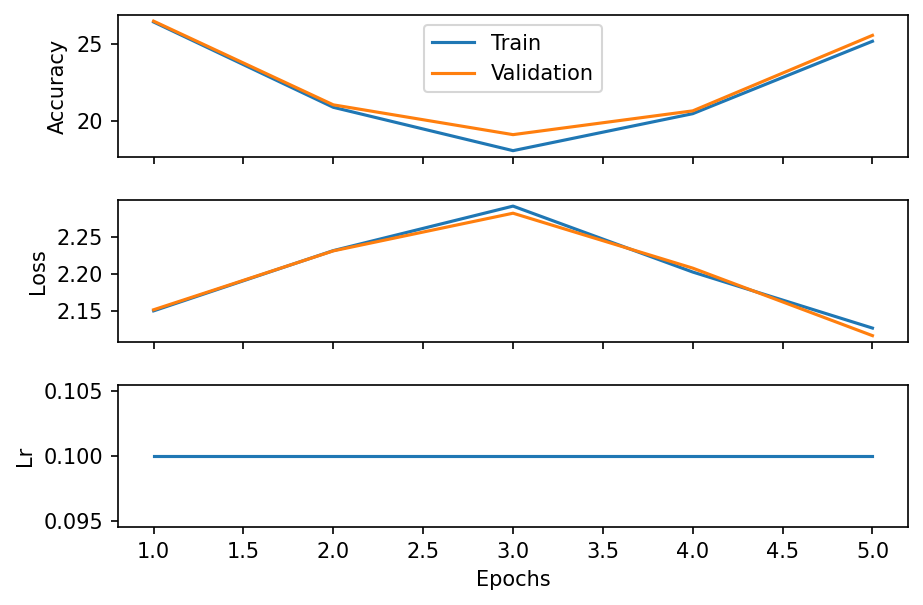

Test acc: 25.36 - Test loss: 2.1146


In [28]:
epoch = 5
batch_size = 1024
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Effet du taux d'apprentissage (lr)

Finalement, observez l'impact du taux d'apprentissage sur l'entraînement.

#### Questions

- Que se passe-t-il s'il est trop grand?

    **D'une manière similaire aux impacts de la taille de la batch, si le taux d'apprentissage au trop grand, les performances sont dégradées d'une manière ou d'une autre. Dépendamment du réseau et de son initialisation, ceci peut prendre la forme d'un apprentissage qui ne s'effectue simplement pas ou d'un apprentissage très instable. Le taux d'apprentissage est donc aussi un hyperparamètre important pour avoir un apprentissage effectif.**

- S'il est trop petit?

    **Si le taux d'apprentissage est trop petit, l'apprentissage se fera d'une manière très lente et parfois il ne se fera pas étant donné la stochaïsticité de l'entraînement.**

Epoch 0 - Train acc: 10.64 - Val acc: 10.75 - Train loss: 2.2889 - Val loss: 2.2899
Epoch 1 - Train acc: 15.75 - Val acc: 15.75 - Train loss: 2.2733 - Val loss: 2.2748
Epoch 2 - Train acc: 19.23 - Val acc: 19.54 - Train loss: 2.2462 - Val loss: 2.2481
Epoch 3 - Train acc: 21.27 - Val acc: 21.76 - Train loss: 2.1980 - Val loss: 2.1998
Epoch 4 - Train acc: 24.42 - Val acc: 24.85 - Train loss: 2.1366 - Val loss: 2.1386


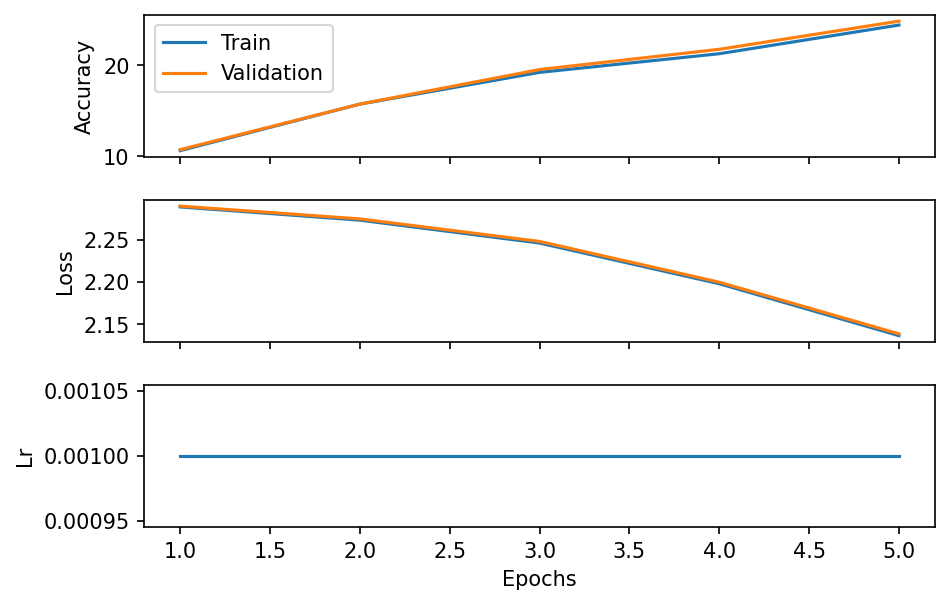

Test acc: 24.49 - Test loss: 2.1359


In [29]:
epoch = 5
batch_size = 64
learning_rate = 0.001

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

Epoch 0 - Train acc: 10.02 - Val acc: 9.93 - Train loss: 2.3832 - Val loss: 2.3846
Epoch 1 - Train acc: 10.02 - Val acc: 9.93 - Train loss: 2.5063 - Val loss: 2.5024
Epoch 2 - Train acc: 10.03 - Val acc: 9.89 - Train loss: 2.3715 - Val loss: 2.3700
Epoch 3 - Train acc: 9.97 - Val acc: 10.11 - Train loss: 2.4328 - Val loss: 2.4277
Epoch 4 - Train acc: 10.03 - Val acc: 9.89 - Train loss: 2.3708 - Val loss: 2.3696


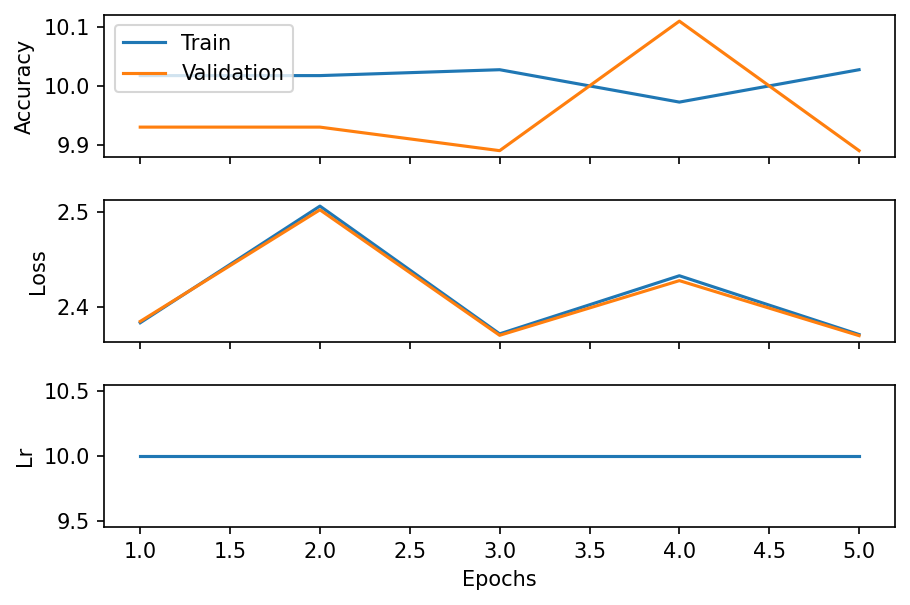

Test acc: 10.00 - Test loss: 2.3702


In [30]:
epoch = 5
batch_size = 64
learning_rate = 10.

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Défi

- Modifiez les hyperparamètres pour améliorer les performances du réseau.<br>
Essayez d'obtenir plus de 65% en test.

- Vous pouvez aussi tenter de battre l'état de l'art: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130

## Utilisation d'une librairie pour l'entraînement

Comme vous l'avez peut-être remarqué, les fonctions `train` et `test` que nous avons utilisées sont bien pratiques. Il existe différentes librairies nous permettant de ne pas devoir définir ces fonctions pour chacun de nos projets. Lorsqu'approprié, nous utiliserons une de ces librairies dans les laboratoires de ce cours. Nous avons choisi d'utiliser la librairie [Poutyne](https://poutyne.org/) qui est développée ici même à l'Université Laval.

Définissons nos hyperparamètres usuels.

In [31]:
epoch = 5
batch_size = 64
learning_rate = 0.1

Poutyne peut prendre en entrée des Numpy arrays ou des tenseurs via sa méthode `fit` ou bien des objets qui sont itérables comme des `DataLoader` de PyTorch via sa méthode `fit_generator`. Définissons donc des `DataLoader` comme le font les fonctions `train` et `test`.

In [32]:
train_loader, valid_loader = train_valid_loaders(cifar, batch_size=batch_size)
test_loader = DataLoader(cifar_test, batch_size=batch_size)

Importons Poutyne.

In [33]:
import poutyne as pt

Procédons maintenant à l'entraînement. La principale classe de Poutyne est la classe [`Model`](https://poutyne.org/model.html) qui nous servira à effectuer l'entraînement. Également, n'hésitez pas à jeter un coup d'oeil à la classe [`Experiment`](https://poutyne.org/experiment.html) qui permet de sauvegarder automatiquement un tas d'information comme des points de sauvegarde (checkpoints) et des logs.

Epoch: 1/5 Step: 625/625 100.00% |█████████████████████████|6.87s loss: 1.868476 acc: 32.682500 val_loss: 1.520863 val_acc: 44.930000
Epoch: 2/5 Step: 625/625 100.00% |█████████████████████████|6.95s loss: 1.417301 acc: 49.542500 val_loss: 1.379764 val_acc: 52.100000
Epoch: 3/5 Step: 625/625 100.00% |█████████████████████████|7.05s loss: 1.232671 acc: 56.500000 val_loss: 1.161633 val_acc: 58.790000
Epoch: 4/5 Step: 625/625 100.00% |█████████████████████████|6.95s loss: 1.088006 acc: 61.817500 val_loss: 1.120310 val_acc: 60.250000
Epoch: 5/5 Step: 625/625 100.00% |█████████████████████████|6.85s loss: 0.973443 acc: 66.280000 val_loss: 1.132260 val_acc: 60.940000


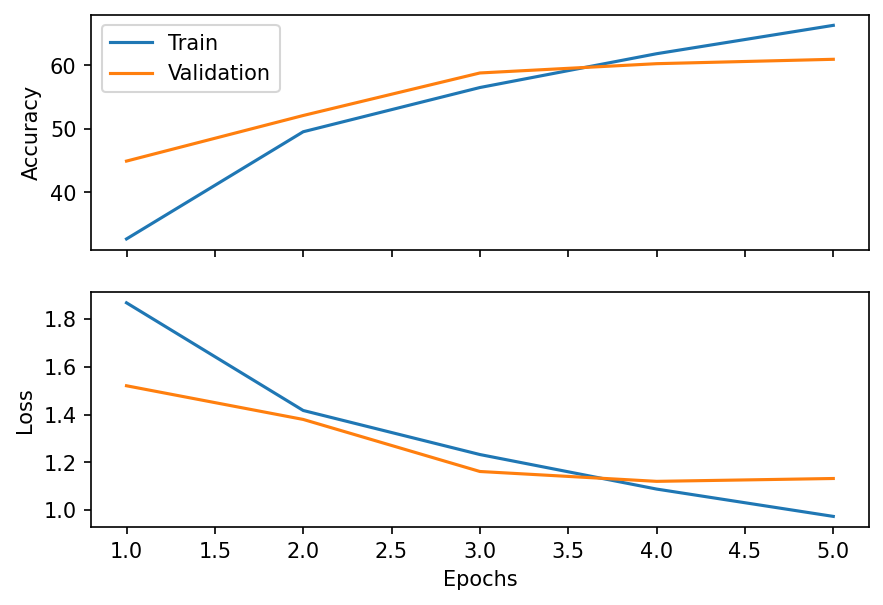

test_loss: 1.1265 test_acc: 61.15


In [34]:
# On instance notre réseau ainsi que l'optimiseur comme à l'habitude.
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

# On crée un objet Model de Poutyne avec la fonction de perte et les métriques souhaitées.
model = pt.Model(net, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

# Comme dit précedemment, on utilise la méthode `fit_generator` pour procéder à l'entraînement.
history = model.fit_generator(train_loader, valid_loader, epochs=epoch)

# La classe History peut aussi prendre un historique de Poutyne en entrée.
History(history).display()

# Finalement, on utilise la fonction evaluate_generator pour calculer la perte et l'exactitude sur
# notre ensemble de test.
test_loss, test_acc = model.evaluate_generator(test_loader)
print('test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

### Pour aller plus loin

Un aspect intéressant de Poutyne est l'utilisation de [callbacks](https://poutyne.org/callbacks.html) qui permettent d'effectuer des actions pendant l'entraînement. Dans l'exemple suivant, on utilise deux types de callbacks: un permettant de faire des points de sauvegarde et l'autre permettant de logger dans un CSV les statistiques d'entraînement.

In [35]:
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

os.makedirs('logs', exist_ok=True)

callbacks = [
    # Effectue des points de sauvegarde après chaque epoch dans le fichier last_epoch.ckpt.
    pt.ModelCheckpoint('logs/last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),

    # Effectue des points de sauvegarde à chaque fois qu'il y a amélioration de l'exactitude
    # en validation. Le nom du fichier va contenir le numéro de l'epoch correspondante.
    pt.ModelCheckpoint('logs/best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),

    # Sauvegarde toutes les stats affichés dans un fichier CSV.
    pt.CSVLogger('logs/log.csv'),
]

model = pt.Model(net, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

history = model.fit_generator(train_loader, valid_loader, epochs=epoch, callbacks=callbacks)

Epoch: 1/5 Step: 625/625 100.00% |█████████████████████████|6.83s loss: 1.866777 acc: 32.837500 val_loss: 1.536629 val_acc: 45.570000
Epoch 1: val_acc improved from -inf to 45.57000, saving file to logs/best_epoch_1.ckpt
Epoch: 2/5 Step: 625/625 100.00% |█████████████████████████|6.93s loss: 1.375103 acc: 51.137500 val_loss: 1.288476 val_acc: 54.390000
Epoch 2: val_acc improved from 45.57000 to 54.39000, saving file to logs/best_epoch_2.ckpt
Epoch: 3/5 Step: 625/625 100.00% |█████████████████████████|6.80s loss: 1.170650 acc: 58.617500 val_loss: 1.121343 val_acc: 60.730000
Epoch 3: val_acc improved from 54.39000 to 60.73000, saving file to logs/best_epoch_3.ckpt
Epoch: 4/5 Step: 625/625 100.00% |█████████████████████████|6.69s loss: 1.009912 acc: 64.550000 val_loss: 1.010136 val_acc: 64.810000
Epoch 4: val_acc improved from 60.73000 to 64.81000, saving file to logs/best_epoch_4.ckpt
Epoch: 5/5 Step: 625/625 100.00% |█████████████████████████|6.62s loss: 0.885112 acc: 69.495000 val_loss

Une fois l'entraînement effectué, on peut aller lire le fichier de log CSV avec la librairie pandas.

In [36]:
pd.read_csv('logs/log.csv')

,epoch,time,lr,loss,acc,val_loss,val_acc
0,1,6.833555,0.1,1.866777,32.8375,1.536629,45.57
1,2,6.930144,0.1,1.375103,51.1375,1.288476,54.39
2,3,6.796485,0.1,1.170650,58.6175,1.121343,60.73
3,4,6.694061,0.1,1.009912,64.5500,1.010136,64.81
4,5,6.622313,0.1,0.885112,69.4950,0.958142,66.60


Étant donné le court entraînement, on devrait avoir obtenu des points de sauvegarde pour chacun des epochs. Amusez vous à charger différents epochs et à regarder l'impact sur l'ensemble de test.

In [37]:
model.load_weights('logs/best_epoch_4.ckpt')
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 4: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

model.load_weights('logs/best_epoch_5.ckpt')
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 5: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

Epoch 4: test_loss: 1.0012 test_acc: 64.78
Epoch 5: test_loss: 0.9598 test_acc: 66.73
